In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DIR = '../Uncertainty_Results/'
SHIFT = 'different_author'
TASK = 'CodeSummary_Module'
model = 'code2vec'

src_dir = os.path.join(DIR, SHIFT, model, TASK)
# {train: array, val: array, test1: array, test2: array, test3: array}
label = torch.load(os.path.join(src_dir, 'truth.res')) # Boolean
vanilla = torch.load(os.path.join(src_dir, 'Vanilla.res'))
entropy = torch.load(os.path.join(src_dir, 'Entropy.res')) 
temp = torch.load(os.path.join(src_dir, 'ModelWithTemperature.res'))
dropout = torch.load(os.path.join(src_dir, 'ModelActivateDropout.res'))
mutant = torch.load(os.path.join(src_dir, 'Mutation.res')) # split [array, array, array, array]
dissector = torch.load(os.path.join(src_dir, 'PVScore.res')) # split [array, array, array]

In [580]:
method_transform = {
    'Vanilla': 'Vanilla',
    'Entropy': 'Entropy',
    'ModelWithTemperature': 'Temp Scale',
    'ModelActivateDropout': 'MC-Dropout',
    'Mutation': 'mMutant',
    'PVScore': 'Dissector',
}
task_transform = {
    'CodeSummary_Module': 'Method name prediction',
    'CodeCompletion_Module': 'Code completion',
}
CSMODELS = ['code2vec', 'coderoberta', 'graphcodebert']
CCMODELS = ['lstm', 'codebert', 'codegpt']

def get_dataframe(shift: str, task: str):
    record = []
    if task == 'CodeSummary_Module':
        models = CSMODELS
    else:
        models = CCMODELS
    for model in models:
        res = torch.load(os.path.join(DIR, shift, model, task, 'uncertainty_eval.res'))
        for ue, outputs in res.items():
            auc_res = outputs['AUC']
            aupr_res = outputs['AUPR']
            brier_res = outputs['Brier']
            if ue in ['Mutation', 'PVScore']:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res[0]['val']*100,
                    'Shift1': auc_res[0]['test1']*100,
                    'Shift2': auc_res[0]['test2']*100,
                    'Shift3': auc_res[0]['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res[0]['val']*100,
                    'Shift1': aupr_res[0]['test1']*100,
                    'Shift2': aupr_res[0]['test2']*100,
                    'Shift3': aupr_res[0]['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res[0]['val']*100,
                    'Shift1': brier_res[0]['test1']*100,
                    'Shift2': brier_res[0]['test2']*100,
                    'Shift3': brier_res[0]['test3']*100,
                }
            else:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res['val']*100,
                    'Shift1': auc_res['test1']*100,
                    'Shift2': auc_res['test2']*100,
                    'Shift3': auc_res['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res['val']*100,
                    'Shift1': aupr_res['test1']*100,
                    'Shift2': aupr_res['test2']*100,
                    'Shift3': aupr_res['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res['val']*100,
                    'Shift1': brier_res['test1']*100,
                    'Shift2': brier_res['test2']*100,
                    'Shift3': brier_res['test3']*100,
                }
            record.append(auc_ins)
            record.append(aupr_ins)
            record.append(brier_ins)
        
    df = pd.DataFrame(record)
    return df

# Rename the shift intensity names
shift_intensity_names = {
    'Validation': 'In-distribution',
    'Shift1': '1',
    'Shift2': '2',
    'Shift3': '3'
}

#### Timeshift CS

In [484]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_time'

time_cs_df = get_dataframe(shift, task)
time_cs_df = time_cs_df[time_cs_df['Metric'] == 'AUC']
time_cs_df

time_cs_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [73.5909, 79.4082, 76.2293, 76.4762, 83.2745, 74.2274,    85.0456, 84.8456, 83.4005, 87.0435, 86.3323, 85.2777,   80.7000, 77.0327, 81.9378, 83.0686, 78.1921, 78.8093],
    'Shift1':     [72.5611, 74.1318, 75.9097, 74.5896, 82.8990, 74.3168,    84.1747, 80.3423, 83.9688, 85.5941, 86.3301, 84.3000,   78.1556, 72.6137, 80.9110, 82.7000, 76.8935, 78.3678],
    'Shift2':     [71.2602, 72.8542, 75.3423, 73.4817, 82.2513, 74.5058,    83.7821, 80.4276, 82.7655, 84.5976, 86.2355, 84.0884,   76.2295, 72.4456, 80.7969, 81.5427, 77.8357, 78.0476],
    'Shift3':     [70.5871, 72.0741, 75.3601, 72.8127, 81.7309, 73.0786,    83.3923, 81.0733, 82.5825, 83.5333, 85.5618, 83.5439,   75.0127, 71.4967, 81.1697, 81.0550, 78.5781, 78.6105],
})

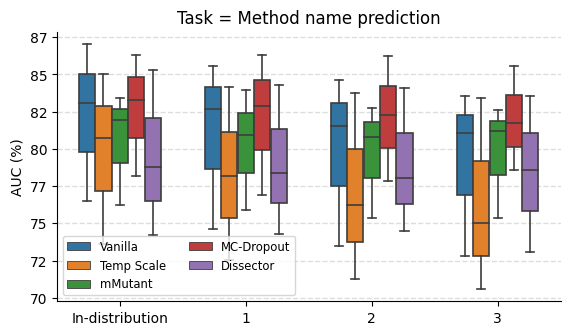

In [936]:
# Reshape the data using melt function
data_melt = pd.melt(
    time_cs_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('Task = Method name prediction')
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.savefig('../Figure/time_cs_auc.pdf', bbox_inches='tight')
plt.show()

#### Projectshift CS

In [338]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_project'

# project_cs_df = get_dataframe(shift, task)
# project_cs_df = project_cs_df[project_cs_df['Metric'] == 'AUC']
# project_cs_df

project_cs_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [81.2892, 85.3722, 82.5648, 82.9977, 82.8536, 82.5188,    86.8978, 88.5987, 89.5117, 88.0474, 90.2631, 90.9689,   91.4884, 88.9076, 86.6064, 91.5600, 87.7090, 87.5938],
    'Shift1':     [77.8627, 82.7522, 80.9355, 80.4149, 81.6695, 81.3008,    82.5598, 77.7263, 87.8978, 86.6201, 89.2601, 88.6126,   87.3997, 83.8937, 84.6484, 89.2702, 85.5348, 86.7621],
    'Shift2':     [75.7582, 80.3515, 78.7409, 78.9116, 78.8401, 79.4517,    80.5980, 78.8665, 86.4451, 83.9887, 87.4989, 86.4601,   85.0793, 84.0066, 82.6597, 88.4281, 83.0254, 84.8238],
    'Shift3':     [74.1181, 78.9998, 76.6045, 77.3065, 77.3322, 77.5220,    78.3853, 77.9501, 84.7071, 81.0400, 85.4043, 85.2681,   82.3378, 78.4503, 80.8207, 86.8490, 81.0739, 82.5028],
})

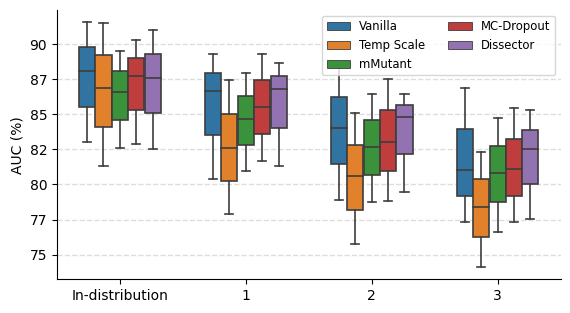

In [937]:
# Reshape the data using melt function
data_melt = pd.melt(
    project_cs_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.savefig('../Figure/project_cs_auc.pdf', bbox_inches='tight')
plt.show()

### Authorshift CS

In [577]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_author'

# author_cs_df = get_dataframe(shift, task)
# author_cs_df = author_cs_df[author_cs_df['Metric'] == 'AUC']
# author_cs_df
author_cs_df = pd.DataFrame({
    # 'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Method': ['mMutant', 'Entropy', 'Temp Scale', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_author'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [84.6731, 86.1166, 86.6442, 82.8763, 87.4954, 84.8384,    87.4313, 87.7106, 88.4278, 90.5411, 89.6022, 87.2213,   79.9495, 85.8462, 80.6001, 85.8042, 82.3221, 80.3173],
    'Shift1':     [82.5498, 85.4952, 83.6260, 80.4938, 85.3121, 82.4678,    85.9949, 87.1119, 86.3121, 88.0739, 87.6909, 84.8442,   77.7735, 84.0066, 79.8000, 85.1643, 79.2199, 76.8078],
    'Shift2':     [80.8409, 83.4705, 82.5874, 79.0099, 85.0864, 83.1459,    84.8369, 83.6186, 85.4382, 87.0527, 86.7853, 80.8816,   76.2879, 82.6892, 78.0328, 84.3304, 78.1404, 76.1340],
    'Shift3':     [79.9859, 81.1186, 80.7585, 78.6638, 83.2161, 82.9193,    83.2632, 80.0471, 84.1198, 86.6159, 85.7160, 79.1445,   75.2730, 78.0613, 77.2049, 82.9288, 77.3184, 74.9342],
})

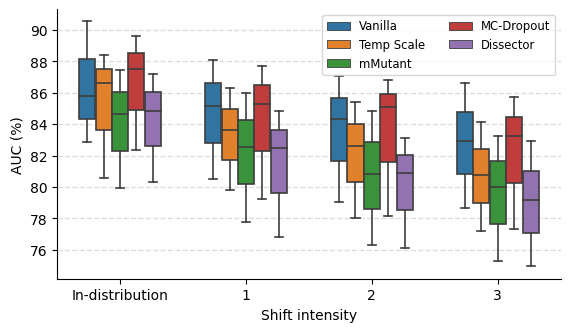

In [938]:
# Reshape the data using melt function
data_melt = pd.melt(
    author_cs_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('Shift intensity')
plt.ylabel('AUC (%)')
plt.savefig('../Figure/author_cs_auc.pdf', bbox_inches='tight')
plt.show()

### Timeshift CC

In [792]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_time'

# time_cc_df = get_dataframe(shift, task)
# time_cc_df = time_cc_df[time_cc_df['Metric'] == 'AUC']
# time_cc_df
time_cc_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [90.057371, 94.213335, 85.567362, 90.097439, 77.901314, 89.462009,
                   85.913402, 93.187556, 88.221278, 85.992579, 86.962363, 84.179083,
                   95.264209, 94.599574, 77.077671, 95.355066, 90.980531, 94.766900],
        'Shift1': [88.689983, 94.393282, 84.458234, 89.894074, 77.665605, 88.462009,
                   83.408543, 93.403884, 87.906157, 84.744651, 85.591776, 84.179083,
                   93.251897, 95.118375, 76.336812, 94.331148, 90.212175, 93.766900],
        'Shift2': [86.558287, 92.660309, 83.935840, 89.604016, 77.476437, 87.825101,
                   80.799668, 91.463029, 87.513415, 84.030205, 84.596434, 83.694576,
                   91.425574, 94.028088, 75.957164, 93.448242, 89.642540, 93.520835],
        'Shift3': [84.546747, 92.650167, 83.311443, 88.571927, 76.829043, 87.013218,
                   78.984302, 90.921669, 87.492693, 83.310430, 83.773818, 82.214343,
                   90.497432, 94.020385, 74.550897, 93.516644, 89.674887, 92.931785],
})

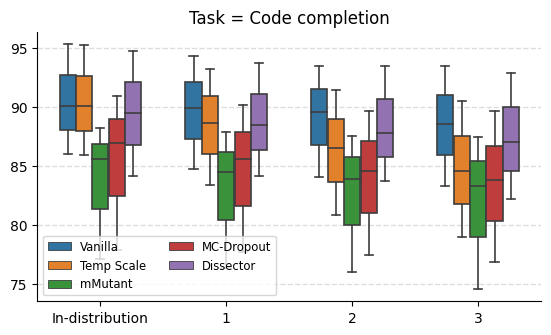

In [939]:
# Reshape the data using melt function
data_melt = pd.melt(
    time_cc_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.title('Task = Code completion')
plt.xlabel('')
plt.ylabel('')
plt.savefig('../Figure/time_cc_auc.pdf', bbox_inches='tight')
plt.show()

### Projectshift CC

In [827]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_project'

# project_cc_df = get_dataframe(shift, task)
# project_cc_df = project_cc_df[project_cc_df['Metric'] == 'AUC']
# project_cc_df
project_cc_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_project'] * 6 + ['different_project'] * 6 + ['different_project'] * 6,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [91.788426, 94.002994, 84.426230, 91.913547, 73.911511, 92.038638,
               85.420518, 93.524027, 88.865109, 85.378159, 85.149608, 84.226601,
               95.998889, 94.113268, 73.323061, 95.988240, 91.977809, 95.883973],
    'Shift1': [89.960156, 85.837561, 81.472428, 91.071379, 69.587164, 90.997980,
               80.528126, 81.954144, 85.232852, 84.041713, 84.116117, 83.864371,
               92.218548, 86.791236, 70.038780, 94.557064, 88.710004, 94.572165],
    'Shift2': [86.994970, 86.574343, 77.775995, 89.511809, 67.167102, 89.458419,
               76.368454, 83.758257, 83.695155, 82.340493, 82.940850, 83.274911,
               89.668135, 86.888459, 68.804132, 93.321035, 86.944238, 93.599955],
    'Shift3': [84.932423, 85.048880, 76.684325, 87.688818, 65.257791, 88.290033,
               74.807386, 79.424085, 81.031253, 80.459384, 80.377717, 81.239069,
               88.952972, 86.008064, 66.774179, 91.203577, 85.280192, 91.904076],
})

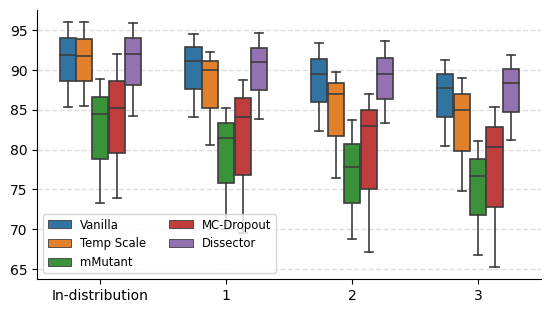

In [940]:
# Reshape the data using melt function
data_melt = pd.melt(
    project_cc_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('')
plt.ylabel('')
plt.savefig('../Figure/project_cc_auc.pdf', bbox_inches='tight')
plt.show()

### Authorshift CC

In [924]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_author'

# author_cc_df = get_dataframe(shift, task)
# author_cc_df = author_cc_df[author_cc_df['Metric'] == 'AUC']
# author_cc_df
author_cc_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_author'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [92.710675, 94.157624, 84.583977, 92.947848, 78.999969, 92.033367,               
                   86.240466, 93.795677, 89.205696, 86.646413, 85.638394, 85.976856,               
                   95.650930, 94.044463, 76.922891, 95.734726, 89.946917, 95.207795],
        'Shift1': [91.168989, 94.800748, 83.569791, 92.474183, 76.832330, 91.800408,               
                   83.030028, 94.577983, 87.293861, 85.397773, 84.738986, 84.751669,               
                   94.363243, 94.836510, 74.693025, 95.067125, 88.889671, 94.587477],
        'Shift2': [89.570981, 92.220400, 82.158638, 91.454590, 74.139887, 91.229118,               
                   80.820220, 90.756916, 86.561732, 84.944625, 83.526401, 83.287660,               
                   92.565676, 92.432118, 72.904223, 94.469555, 87.771874, 93.049905],
        'Shift3': [88.092231, 92.639304, 81.499390, 90.669593, 72.640334, 90.221671, 
                   78.522087, 91.848935, 85.639824, 83.880761, 82.919698, 82.848704,
                   91.967359, 93.109261, 71.253575, 93.965705, 87.254396, 92.104877],
})

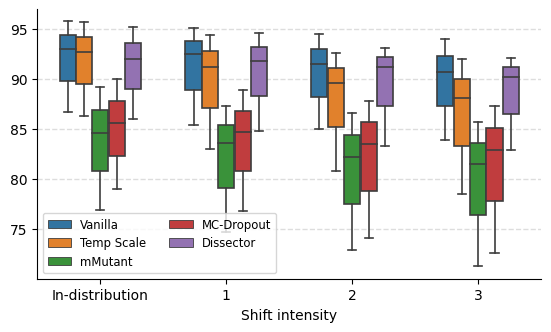

In [941]:
# Reshape the data using melt function
data_melt = pd.melt(
    author_cc_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method',
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('Shift intensity')
plt.ylabel('')
plt.savefig('../Figure/author_cc_auc.pdf', bbox_inches='tight')
plt.show()